# !!Remember to add comma before the NOTES!! Organise the variable NAMES! MAGIC Numbers!

In [1]:
# import

## final transaction

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window
import numpy as np
from pyspark.sql.functions import *

In [3]:
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

22/10/08 15:42:28 WARN Utils: Your hostname, hexiangyideMacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.13.185.7 instead (on interface en0)
22/10/08 15:42:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/08 15:42:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# read the given transaction datasets
ori_transaction1 = spark.read.parquet('../data/tables/transactions_20210228_20210827_snapshot').sort('order_datetime')
ori_transaction2 = spark.read.parquet('../data/tables/transactions_20210828_20220227_snapshot').sort('order_datetime')
ori_transaction3 = spark.read.parquet('../data/tables/transactions_20220228_20220828_snapshot').sort('order_datetime')

# read the given consumer datasets
tbl_consumer = spark.read.option("delimiter", "|").option("header",True).csv("../data/tables/tbl_consumer.csv")
consumer_detail = spark.read.parquet('../data/tables/consumer_user_details.parquet')

# read the fraud dataset
consumer_fraud = spark.read.option("header",True).csv('../data/tables/consumer_fraud_probability.csv')

# merge all the transaction data
ori_transaction = ori_transaction1.union(ori_transaction2)
ori_transaction = ori_transaction.union(ori_transaction3)
ori_transaction = ori_transaction.drop('order_id')
ori_transaction = ori_transaction.dropna(how='any')
ori_transaction = ori_transaction.filter("order_datetime >= '2021-02-28'")
ori_transaction = ori_transaction.filter("order_datetime <= '2022-08-28'")


# delete outliers
wind = Window.partitionBy('merchant_abn')
q1= F.expr('percentile_approx(dollar_value, 0.25)')
q3= F.expr('percentile_approx(dollar_value, 0.75)')
testq = ori_transaction.withColumn('q1', q1.over(wind))
testq = testq.withColumn('q3', q3.over(wind))
testq = testq.withColumn('IQR', testq['q3']-testq['q1'])
dele_out = testq.where((testq["dollar_value"] <= testq["q1"]+1.5*testq["IQR"]) & (testq["dollar_value"] >= testq["q1"]-1.5*testq["IQR"]))
ori_transaction = dele_out.drop('q1','q3','IQR','order_id')

# give a definition, if a single transaction is over $10000, this is a big order
big_order_value = 10000
ori_transaction = ori_transaction.withColumn(
    "whether_bigorder",
    F.when(F.col('dollar_value')>=big_order_value, 1).otherwise(0))

# consumer datasets
consumer = consumer_detail.join(tbl_consumer, consumer_detail.consumer_id == tbl_consumer.consumer_id).drop(tbl_consumer.consumer_id)
consumer = consumer.select('user_id', 'postcode')

# change to the date format
consumer_fraud = consumer_fraud.select(col("user_id"),col("fraud_probability"),to_date(col("order_datetime"),"yyyy-MM-dd").alias("date"))

#filter the range for the fraud data
consumer_fraud = consumer_fraud.where(
        #clean the data outside the date range
        (F.col('date') >= '2021-02-28')& 
        (F.col('date') <= '2022-08-28'))

consumer_fraud_grouped = consumer_fraud.groupBy('user_id').agg(F.avg('fraud_probability').alias('average_prob_con'))
consumer_fraud_final = consumer_fraud_grouped.withColumn(
    "whether_fraud",
    F.when(F.col('average_prob_con')>=70, 1).otherwise(0))

consumer_final = consumer.join(consumer_fraud_final, consumer.user_id == consumer_fraud_final.user_id).drop(consumer_fraud_final.user_id).fillna(0).fillna(0)
consumer_final.write.parquet(f"../data/curated/final_consumer.parquet")

transaction = ori_transaction.join(consumer_final, ori_transaction.user_id == consumer_final.user_id).drop(consumer_final.user_id)
transaction = transaction.sort(transaction.user_id)
transaction.write.parquet(f"../data/curated/final_transaction.parquet")

22/10/08 15:43:11 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
22/10/08 15:43:11 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
22/10/08 15:43:15 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers


## final merchant

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import numpy as np
from pyspark.sql.functions import *
import pandas as pd

In [6]:
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

In [7]:
# read the given merchant datasets
merchant_fraud = spark.read.option("header",True).csv('../data/tables/merchant_fraud_probability.csv')
tbl_merchants = spark.read.parquet('../data/tables/tbl_merchants.parquet')

# check the range of date

merchant_fraud = merchant_fraud.select(col("merchant_abn"),col("fraud_probability"),to_date(col("order_datetime"),"yyyy-MM-dd").alias("date"))

#filter the range for the fraud data
merchant_fraud = merchant_fraud.where(
        #clean the data outside the date range
        (F.col('date') >= '2021-02-28')& 
        (F.col('date') <= '2022-08-28'))
merchant_fraud_grouped = merchant_fraud.groupBy('merchant_abn').agg(F.count('fraud_probability').alias('fraud_count_abn'))

# preprocess the given merchant datasets
tbl_merchants_pd = tbl_merchants.toPandas()
for i in range(int(tbl_merchants_pd['tags'].count())):
    tbl_merchants_pd['tags'].iloc[i] = tbl_merchants_pd['tags'].iloc[i].replace(r'[', r'(').replace(r']', r')')
tbl_merchants_pd['tags'] = tbl_merchants_pd['tags'].str.lower()

# split the column into three columns and give names to the columns
merchant_tags = tbl_merchants_pd['tags'].str.split(')', expand=True)
for row in range(int(len(merchant_tags))):
    for col in range(3):
        merchant_tags.iloc[row,col] = merchant_tags.iloc[row,col].replace(r'((', r'').replace(r', (', r'').replace(r'take rate:', r'')
merchant_tags.rename(columns = {0 : 'Store_type', 1 : 'Revenue_levels', 2 : 'Take_rate'}, inplace = True)
merchant_tags = merchant_tags[['Store_type', 'Revenue_levels', 'Take_rate']]

tbl_merchants_pd[['Store_type', 'Revenue_levels', 'Take_rate']] = merchant_tags[['Store_type', 'Revenue_levels', 'Take_rate']]


for i in range(len(tbl_merchants_pd)):
    tbl_merchants_pd['Store_type'][i] = ' '.join(tbl_merchants_pd['Store_type'][i].split())

# export the merchant dataset
merchants = tbl_merchants_pd[['merchant_abn', 'Store_type', 'Revenue_levels', 'Take_rate']]
merchants.to_parquet(f"../data/curated/final_merchant.parquet")

/var/folders/4w/p31d1t_x5pqbppcsm7p9kxt00000gn/T/ipykernel_74274/3037550658.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tbl_merchants_pd['tags'].iloc[i] = tbl_merchants_pd['tags'].iloc[i].replace(r'[', r'(').replace(r']', r')')
/var/folders/4w/p31d1t_x5pqbppcsm7p9kxt00000gn/T/ipykernel_74274/3037550658.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tbl_merchants_pd['Store_type'][i] = ' '.join(tbl_merchants_pd['Store_type'][i].split())


## read external data

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [9]:
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

22/10/08 15:43:21 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [10]:
import os
import numpy as np
import pandas as pd
import zipfile
import pandas as pd
import geopandas as gpd
from dbfread import DBF
from urllib.request import urlretrieve
from urllib.error import HTTPError
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

In [11]:
#Go back one level from notebook to data 
output_relative_dir = '../data/'

if not os.path.exists(output_relative_dir):
    os.makedirs(output_relative_dir)
    
for target_dir in ('external','outer'):
    if not os.path.exists(output_relative_dir + target_dir):
        os.makedirs(output_relative_dir + target_dir)

# Download census data
url = "https://www.abs.gov.au/census/find-census-data/datapacks/download/2021_GCP_SA2_for_AUS_short-header.zip"#year-month.parquet
output_dir = "../data/outer/census.zip"
# download
urlretrieve(url, output_dir) 

files = zipfile.ZipFile('../data/outer/census.zip','r')

for file in files.namelist():
    files.extract(file, f"../data/outer/census")

types = ["A", "B"]
for type in types:
    G04= spark.read.option("header",True).csv(f'../data/outer/census/2021 Census GCP Statistical Area 2 for AUS/2021Census_G04{type}_AUST_SA2.csv') #read the parquet 
    G04 = G04.na.drop(subset=G04.columns)
    G04.write.mode("overwrite").parquet(f"../data/external/census_data_2021_04{type}.parquet")

types = ["A", "B", "C"]
for type in types:
    G17= spark.read.option("header",True).csv(f'../data/outer/census/2021 Census GCP Statistical Area 2 for AUS/2021Census_G17{type}_AUST_SA2.csv') #read the parquet 
    G17 = G17.na.drop(subset=G17.columns)

    G17.write.mode("overwrite").parquet(f"../data/external/census_data_2021_17{type}.parquet")

# Download postcode and SA2 data
url = "http://github.com/matthewproctor/australianpostcodes/zipball/master"
output_dir = "../data/outer/total_pto2.zip"
# download
urlretrieve(url, output_dir) 

files = zipfile.ZipFile('../data/outer/total_pto2.zip','r')
for file in files.namelist():
    files.extract(file, f"../data/outer/total_pto2")

post_sa2= spark.read.option("header",True).csv('../data/outer/total_pto2/matthewproctor-australianpostcodes-6f8a994/australian_postcodes.csv') 
print(post_sa2.dtypes)
post_sa2 = post_sa2.select("id", "postcode", "Lat_precise", "Long_precise", "SA2_MAINCODE_2016")
print(post_sa2.count() - post_sa2.na.drop().count())
post_sa2 = post_sa2.na.drop()
#177 rows with nulls dropped

#get the average latitude and longitude of the postcode if it have duplicates
post_sa2 = post_sa2\
    .withColumn("Lat_double", post_sa2["Lat_precise"].cast("double"))\
    .withColumn("Long_double", post_sa2["Long_precise"].cast("double"))
post_sa2 = post_sa2\
    .groupBy("postcode", "SA2_MAINCODE_2016")\
    .agg(F.avg("Lat_double").alias("avg_lat"), F.avg("Long_double").alias("avg_long"))

post_sa2.write.mode("overwrite").parquet("../data/external/postcode_SA2.parquet")

# Download SA2 2021 information
url = "https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files/SA2_2021_AUST_SHP_GDA2020.zip" 
#year-month.parquet
output_dir = "../data/outer/2021sa2_shapefile.zip"
# download
urlretrieve(url, output_dir) 
print("complete")

files = zipfile.ZipFile('../data/outer/2021sa2_shapefile.zip','r')
for file in files.namelist():
    files.extract(file, f"../data/outer/2021sa2_shapefile")

# Download shapefile for each SA2 region
# !!!WARNING!!! THIS CODE IS GOING TO TAKE 10 MINUTES
def get_shapefile(url):
    geojson_option = "?_profile=oai&_mediatype=application/geo+json"
    try:
        shape = str(gpd.read_file(url + geojson_option).iat[0,-1])
    except HTTPError:
        shape = ""
    return shape

get_shapefile_udf = udf(lambda a: get_shapefile(a),StringType())

path = r'../data/outer/2021sa2_shapefile/SA2_2021_AUST_GDA2020.dbf' 
table = DBF(path)
sa2_pd_temp = pd.DataFrame(iter(table))
sa2_2021_temp = spark.createDataFrame(sa2_pd_temp) 

sa2_2021_vic = sa2_2021_temp.filter(F.col("STE_NAME21")=="Victoria")
sa2_2021_vic_w_geo = sa2_2021_vic.withColumn("geometry", get_shapefile_udf(F.col("LOCI_URI21")))


22/10/08 15:43:29 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


[('id', 'string'), ('postcode', 'string'), ('locality', 'string'), ('state', 'string'), ('long', 'string'), ('lat', 'string'), ('dc', 'string'), ('type', 'string'), ('status', 'string'), ('sa3', 'string'), ('sa3name', 'string'), ('sa4', 'string'), ('sa4name', 'string'), ('region', 'string'), ('Lat_precise', 'string'), ('Long_precise', 'string'), ('SA1_MAINCODE_2011', 'string'), ('SA1_MAINCODE_2016', 'string'), ('SA2_MAINCODE_2016', 'string'), ('SA2_NAME_2016', 'string'), ('SA3_CODE_2016', 'string'), ('SA3_NAME_2016', 'string'), ('SA4_CODE_2016', 'string'), ('SA4_NAME_2016', 'string'), ('RA_2011', 'string'), ('RA_2016', 'string'), ('MMM_2015', 'string'), ('MMM_2019', 'string'), ('ced', 'string'), ('altitude', 'string'), ('chargezone', 'string'), ('phn_code', 'string'), ('phn_name', 'string'), ('lgaregion', 'string'), ('electorate', 'string'), ('electoraterating', 'string')]
177
complete


too big can't write to parquet

In [12]:
sa2_2021_vic_w_geo = sa2_2021_vic_w_geo.select("SA2_CODE21", "SA2_NAME21", "geometry")
sa2_2021_vic_w_geo.write.option("maxRecordsPerFile", 1).mode("overwrite").parquet("../data/external/SA2_2021_VIC_shapefile.parquet")

#sa2_2021_vic_w_geo.write.option("maxRecordsPerFile", 20).mode("overwrite").parquet("../data/external/SA2_2021_VIC_shapefile.parquet")
#sa2_2021_ = sa2_2021_temp.select("SA2_CODE21")
#sa2_2021_.count

In [13]:
# Download file with 2016 SA2 info and 2021 SA2 info
url = "https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/correspondences/CG_SA2_2016_SA2_2021.csv"
output_dir = "../data/outer/correspondences.csv"
# download
urlretrieve(url, output_dir) 

correspondences= spark.read.option("header",True).csv('../data/outer/correspondences.csv') #read the parquet 
correspondences = correspondences.na.drop()
correspondences.write.parquet("../data/external/correspondences.parquet")

# Find 2016 post code and 2021 sa2 correspondence
print(post_sa2.dtypes)
print(correspondences.dtypes)
post_sa2_2021 = correspondences.join(post_sa2,correspondences.SA2_MAINCODE_2016 == post_sa2.SA2_MAINCODE_2016,"left") 

# JOIN tables
post_sa2_2021 = post_sa2_2021.drop("SA2_NAME_2016", "SA2_MAINCODE_2016")
post_sa2_2021.write.mode("overwrite").parquet("../data/external/postcode_sa2_conrrespondences.parquet")

[('postcode', 'string'), ('SA2_MAINCODE_2016', 'string'), ('avg_lat', 'double'), ('avg_long', 'double')]
[('SA2_MAINCODE_2016', 'string'), ('SA2_NAME_2016', 'string'), ('SA2_CODE_2021', 'string'), ('SA2_NAME_2021', 'string'), ('RATIO_FROM_TO', 'string'), ('INDIV_TO_REGION_QLTY_INDICATOR', 'string'), ('OVERALL_QUALITY_INDICATOR', 'string'), ('BMOS_NULL_FLAG', 'string')]


## census_age&income

In [14]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from operator import add
from functools import reduce

In [15]:
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

In [22]:
# read the external census datasets
census_04A_age = spark.read.parquet('../data/external/census_data_2021_04A.parquet')
census_04B_age = spark.read.parquet('../data/external/census_data_2021_04B.parquet')
census_17A_income = spark.read.parquet('../data/external/census_data_2021_17A.parquet')
census_17B_income = spark.read.parquet('../data/external/census_data_2021_17B.parquet')
census_17C_income = spark.read.parquet('../data/external/census_data_2021_17C.parquet')
correspondences = spark.read.parquet('../data/external/correspondences.parquet')
postcode = spark.read.parquet('../data/external/postcode_SA2.parquet/')

#Merge the age dataframe
Age_Data = census_04A_age.join(census_04B_age, census_04A_age.SA2_CODE_2021 == census_04B_age.SA2_CODE_2021).drop(census_04B_age.SA2_CODE_2021)

#Select the column in the age dataframe (18-65) and calculate the sum
Age_Data_select = Age_Data.select(Age_Data.columns[0::18])
Age_Data_total = Age_Data_select.withColumn('result',reduce(add, [F.col(x) for x in Age_Data_select.columns[5:14]]))
Age_Data_total = Age_Data_total.select("SA2_CODE_2021","result","Tot_P")

Age_Data_rate = Age_Data_total.withColumn("age_percentage", Age_Data_total.result /Age_Data_total.Tot_P)
Age_Data_rate = Age_Data_rate.select("SA2_CODE_2021","age_percentage")

income = census_17A_income.join(census_17B_income, census_17A_income.SA2_CODE_2021 == census_17B_income.SA2_CODE_2021).drop(census_17B_income.SA2_CODE_2021)
income_data = income.join(census_17C_income, income.SA2_CODE_2021 == census_17C_income.SA2_CODE_2021).drop(census_17C_income.SA2_CODE_2021)

income_data_del = income_data.select(income_data.columns[0::10])
income_data_select = income_data_del.withColumn('result',reduce(add, [F.col(x) for x in income_data_del.columns[44:50]]))
income_Data_total = income_data_select.select("SA2_CODE_2021","result","P_Tot_Tot")

income_Data_total = income_Data_total.withColumn("income_percentage", income_Data_total.result / income_Data_total.P_Tot_Tot)
income_Data_total = income_Data_total.select("SA2_CODE_2021","income_percentage")

census_data = income_Data_total.join(Age_Data_rate, income_Data_total.SA2_CODE_2021 == Age_Data_rate.SA2_CODE_2021).drop(Age_Data_rate.SA2_CODE_2021)
census_data.write.parquet('../data/curated/final_census.parquet')


AnalysisException: path file:/Users/hexiangyi/Desktop/generic-buy-now-pay-later-project-group-16-project2-fighting-group/data/curated/final_census.parquet already exists.

## Combine table

In [17]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import numpy as np
from pyspark.sql.functions import round
from pyspark.sql import Window

In [23]:
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

In [24]:
# read the tables
transaction = spark.read.parquet('../data/curated/final_transaction.parquet')
merchants = spark.read.parquet('../data/curated/final_merchant.parquet')
consumer = spark.read.parquet('../data/curated/final_consumer.parquet')
census = spark.read.parquet('../data/curated/final_census.parquet')
post_sa2_2021 = spark.read.parquet("../data/external/postcode_sa2_conrrespondences.parquet")
prediction = spark.read.parquet('../data/curated/prediction/predicted_dollar_value0.parquet')
for counts in range(1,45):
    counts =  str(counts)
    prediction_add = spark.read.parquet(f"../data/curated/prediction/predicted_dollar_value{counts}.parquet")
    prediction = prediction.union(prediction_add)
prediction

# group the tables, get the number of big order per merchant
grouped_transaction = transaction.groupBy('merchant_abn').agg(
    F.sum('dollar_value').alias('Amount'), F.count('dollar_value').alias('Count'), 
    F.sum('whether_bigorder').alias('count_of_bigorder')).sort('merchant_abn')
grouped_transaction.drop(F.col('order_id'))

# get the monthly average features
number_of_months = 18
grouped_transaction = grouped_transaction.withColumn('Avg_amount_monthly', round(grouped_transaction['Amount']/number_of_months, 2))
grouped_transaction = grouped_transaction.withColumn('Avg_count_monthly', round(grouped_transaction['Count']/number_of_months, 2))
grouped_transaction = grouped_transaction.withColumn('Order_avg_value', round(grouped_transaction.Amount/grouped_transaction.Count,2))
grouped_transaction = grouped_transaction.drop('Amount','Count')


merchant_data1 = merchants.join(grouped_transaction, merchants.merchant_abn == grouped_transaction.merchant_abn).drop(grouped_transaction.merchant_abn)
merchant_data1 = merchant_data1.drop('Amount','Count')
ori_transaction_1 = transaction.groupby('merchant_abn','user_id').agg(
    F.count('user_id').alias('count'), 
    F.avg('average_prob_con').alias('avg_prob_fraud_cus'),
    F.avg('whether_fraud').alias('whether_fraud'))

o_t = ori_transaction_1.groupby('merchant_abn').agg(
    F.count('user_id').alias('cnt'), 
    F.avg('avg_prob_fraud_cus').alias('avg_prob_fraud_cus'),
    F.sum('whether_fraud').alias('num_of_fraud'))

cus_per_mon = o_t.withColumn('prob_of_fraud', o_t.num_of_fraud/o_t.cnt)
cus_per_mon = cus_per_mon.withColumn('count_cus_per_mon', round(o_t['cnt']/number_of_months, 2))
cus_per_mon = cus_per_mon.drop('cnt')
cus_per_mon = cus_per_mon.drop('num_of_fraud')
ori_transaction_2 = transaction.groupby('merchant_abn', 'user_id').count()

ori_con_drop = ori_transaction_2.withColumn(
    "fixed_cus_num",
    F.when(F.col("count") >= 5, 1).otherwise(0))

ori_con_fix = ori_con_drop.groupby('merchant_abn').agg(F.sum('fixed_cus_num').alias('fix_cus_num'))

user_info = cus_per_mon.join(ori_con_fix, cus_per_mon.merchant_abn == ori_con_fix.merchant_abn).drop(ori_con_fix.merchant_abn)
user_info = user_info.drop('total_cus_num')
merchant_abn_and_consumer_id = transaction['merchant_abn', 'user_id']
user_id_and_postcode = consumer[['postcode','user_id']]

merchant_and_consumer_postcode = merchant_abn_and_consumer_id.join(user_id_and_postcode,['user_id'])
merchant_and_consumer_postcode = merchant_and_consumer_postcode['merchant_abn', 'postcode']

#https://stackoverflow.com/questions/36654162/mode-of-grouped-data-in-pyspark
counts = merchant_and_consumer_postcode.groupBy(['merchant_abn', 'postcode']).count().alias('counts')
merchant_postcode = (counts
          .groupBy('merchant_abn')
          .agg(F.max(F.struct(F.col('count'),
                              F.col('postcode'))).alias('max'))
          .select(F.col('merchant_abn'), F.col('max.postcode'))
         )

merchant_info = merchant_data1.join(merchant_postcode, merchant_data1.merchant_abn == merchant_postcode.merchant_abn).drop(merchant_data1.merchant_abn)
post_census = post_sa2_2021.join(census, post_sa2_2021.SA2_CODE_2021 == census.SA2_CODE_2021).drop(census.SA2_CODE_2021)
post_census_1 = post_census.groupBy('postcode')\
.agg(F.avg(F.col('income_percentage')).alias("avg_income_percentage"),
F.avg(F.col('age_percentage')).alias('avg_age_percentage'))
post_census_2 = post_census_1.select(post_census_1.postcode.cast('int'),post_census_1.avg_income_percentage, post_census_1.avg_age_percentage)

semifinal = merchant_info.join(user_info, merchant_info.merchant_abn == user_info.merchant_abn).drop(merchant_info.merchant_abn)
final = semifinal.join(post_census_2, semifinal.postcode == post_census_2.postcode, 'left').drop(post_census_2.postcode)
final = final.na.fill(value=0,subset=["avg_income_percentage", "avg_age_percentage"])
final = final.withColumn('Take_rate', final.Take_rate*final.Avg_amount_monthly)
final = final.join(prediction, final.merchant_abn == prediction.merchant_abn).drop(prediction.merchant_abn)
final.write.parquet('../data/curated/merchant_info.parquet')

22/10/08 15:50:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:11 WARN RowBasedKeyValueBatch: Calling spill() on

22/10/08 15:50:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:15 WARN RowBasedKeyValueBatch: Calling spill() on

22/10/08 15:50:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/08 15:50:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:21 WARN RowBasedKeyValueBatch: Calling spill() on

22/10/08 15:50:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/08 15:50:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/08 15:50:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:27 WARN RowBasedKeyValueBatch: Calling spill() on

22/10/08 15:50:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/08 15:50:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


## geovisualisation

In [25]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col
import pandas as pd
import geopandas as gpd
import folium
from shapely.wkt import loads
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

In [26]:
geospark = spark.read.parquet('../data/external/SA2_2021_VIC_shapefile.parquet/')
census = spark.read.parquet('../data/curated/final_census.parquet')
vic_data = geospark.join(census, geospark.SA2_CODE21 == census.SA2_CODE_2021, "left").drop(census.SA2_CODE_2021)

def visualisation(col_name, vic_data,geospark, title):
    data = vic_data.groupBy("SA2_CODE21").agg(F.avg(col_name).alias(col_name))
    pdf = geospark.select("SA2_CODE21", "geometry").toPandas()
    pdf['geometry'] = gpd.GeoSeries.from_wkt(pdf['geometry'])
    gdf = gpd.GeoDataFrame(pdf, geometry='geometry')
    geoJSON = gdf[['SA2_CODE21', 'geometry']].drop_duplicates('SA2_CODE21').to_json()
    m = folium.Map(location=[-37.84, 144.95], tiles="Stamen Terrain", zoom_start=10)
    # refer to the folium documentations on how to plot aggregated data.
    c = folium.Choropleth(
        geo_data=geoJSON, # geoJSON 
        name='choropleth', # name of plot
        data=data.toPandas(), # data source
        columns=['SA2_CODE21',col_name], # the columns required
        key_on='properties.SA2_CODE21', # this is from the geoJSON's properties
        fill_color='YlOrRd', # color scheme
        nan_fill_color='black',
        legend_name=col_name
    )

    map = c.add_to(m)

    map.save('../plots/foliumChoropleth_'+col_name+'.html')
    map

visualisation("income_percentage", vic_data, geospark,"average income percentage by SA2")
visualisation("age_percentage", vic_data, geospark,"age_percentage")


## Visualization

In [27]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd
import seaborn as sns
import numpy as np

In [28]:
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

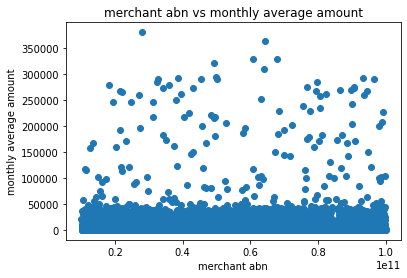

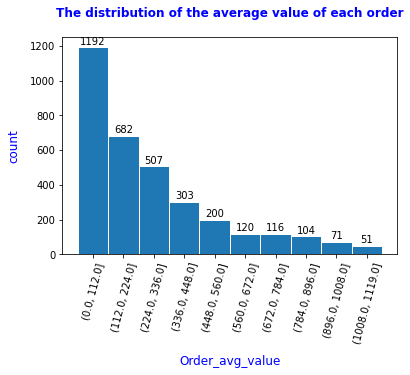

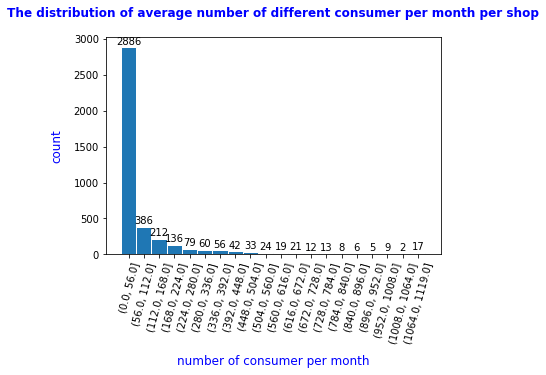

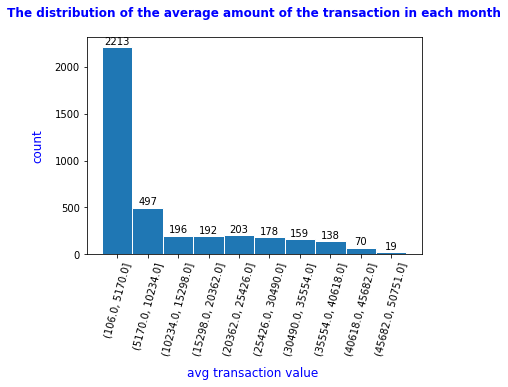

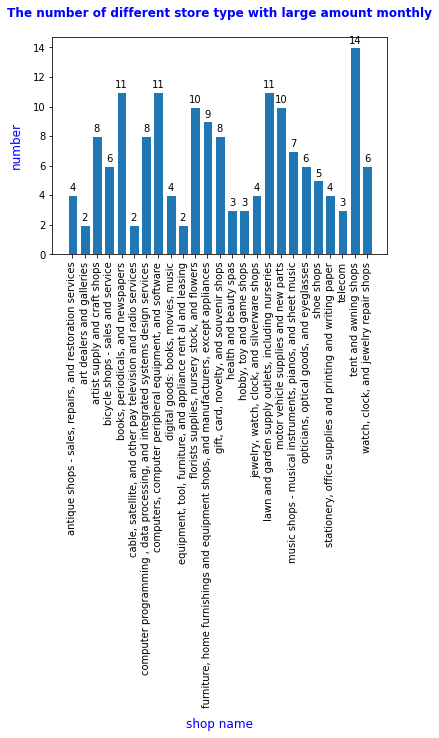

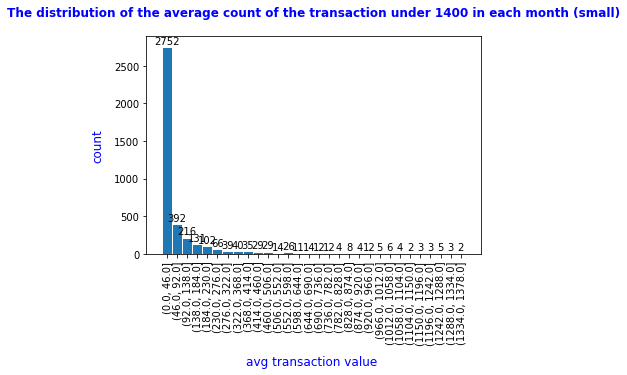

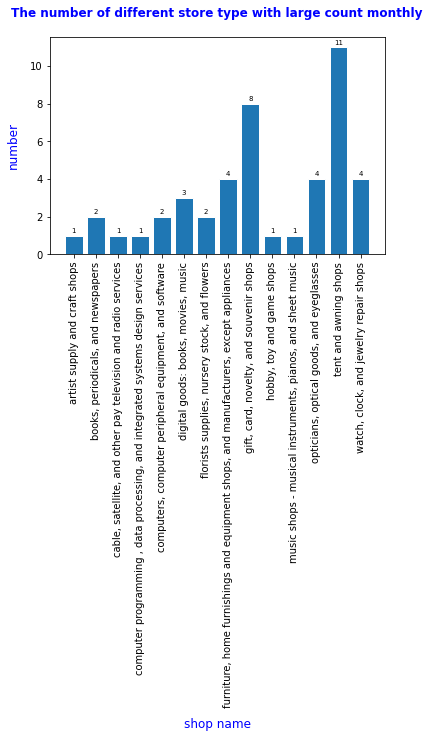

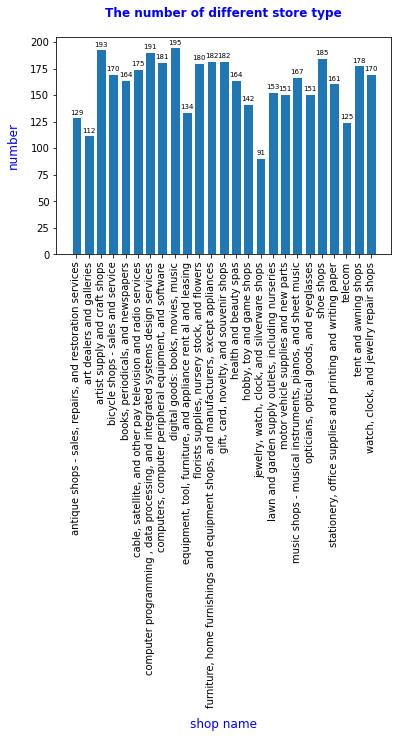

In [29]:
merchant_info = spark.read.parquet('../data/curated/merchant_info.parquet')
merchant_info = merchant_info.toPandas()
#View the relationship between travel_time_mins vs tip_amount
# plot

##plt.scatter(merchant_info['Order_avg_value'], merchant_info['num_of_fraud'])
# scatter plot for abn vs monthly average amount
plt.scatter(merchant_info['merchant_abn'], merchant_info['Avg_amount_monthly'])
plt.xlabel('merchant abn')
plt.ylabel('monthly average amount')
plt.title('merchant abn vs monthly average amount')
plt.savefig('../plots/abn_vs_amount.png', bbox_inches='tight')

def get_bin(df,bar_num):
    bar_list = []
    max_value = int(df.max()+1)
    min_value = int(df.min())
    t_bar_range = max_value - min_value
    bar_range = np.round(t_bar_range/bar_num)
    for i in range(0 ,bar_num):
        num = min_value + i*bar_range
        bar_list.append(num)
    bar_list.append(max_value)
    return bar_list
# Order_avg_value
bins = get_bin(merchant_info['count_cus_per_mon'],10)

dff_count_cus_per_mon = merchant_info.groupby(pd.cut(merchant_info['Order_avg_value'], bins=bins))['fix_cus_num'].count()
dff_count_cus_per_mon = dff_count_cus_per_mon.to_frame().reset_index()
dff = dff_count_cus_per_mon.rename(columns={"Order_avg_value": "index", "fix_cus_num": "count"})

fig, ax = plt.subplots()

y = dff['count']

bars = ax.bar(
    x = range(1,11),
    height = y, edgecolor='white',
    tick_label = dff['index'], width = 1
)
plt.xticks(rotation=75)

#add the average tip_amount number on the top of each bar chart
ax.bar_label(bars, padding=1, color = 'black', fontsize=10)
ax.xaxis.grid(False)

#show the bar chart and add the title and labels
ax.set_ylabel('count', labelpad = 10, color = 'blue', fontsize=12)
ax.set_xlabel('Order_avg_value', labelpad = 10, color = 'blue', fontsize=12)
ax.set_title('The distribution of the average value of each order', pad = 20, color = 'blue', weight = 'bold')
plt.savefig('../plots/avg_value_per_order.png', bbox_inches='tight')
# count_cus_per_mon
bins = get_bin(merchant_info['count_cus_per_mon'],20)

dff_count_cus_per_mon = merchant_info.groupby(pd.cut(merchant_info['count_cus_per_mon'], bins=bins))['fix_cus_num'].count()
dff_count_cus_per_mon = dff_count_cus_per_mon.to_frame().reset_index()
dff = dff_count_cus_per_mon.rename(columns={"count_cus_per_mon": "index", "fix_cus_num": "count"})

fig, ax = plt.subplots()

y = dff['count']

bars = ax.bar(
    x = range(1,21),
    height = y, edgecolor='white',
    tick_label = dff['index'], width = 1
)
plt.xticks(rotation=75)

#add the average tip_amount number on the top of each bar chart
ax.bar_label(bars, padding=1, color = 'black', fontsize=10)
ax.xaxis.grid(False)

#show the bar chart and add the title and labels
ax.set_ylabel('count', labelpad = 10, color = 'blue', fontsize=12)
ax.set_xlabel('number of consumer per month', labelpad = 10, color = 'blue', fontsize=12)
ax.set_title('The distribution of average number of different consumer per month per shop', pad = 20, color = 'blue', weight = 'bold')
plt.savefig('../plots/num_of_customer_per_month.png')
merchant_info_amount_small = merchant_info[merchant_info['Avg_amount_monthly'] <= 51000]
merchant_info_amount_large = merchant_info[merchant_info['Avg_amount_monthly'] > 51000]
# Avg_amount_monthly small
bins = get_bin(merchant_info_amount_small['Avg_amount_monthly'],10)

dff_count_cus_per_mon = merchant_info_amount_small.groupby(pd.cut(merchant_info['Avg_amount_monthly'], bins=bins))['fix_cus_num'].count()
dff_count_cus_per_mon = dff_count_cus_per_mon.to_frame().reset_index()
dff = dff_count_cus_per_mon.rename(columns={"Avg_amount_monthly": "index", "fix_cus_num": "count"})

fig, ax = plt.subplots()

y = dff['count']

bars = ax.bar(
    x = range(1,11),
    height = y, edgecolor='white',
    tick_label = dff['index'], width = 1
)
plt.xticks(rotation=75)

#add the average tip_amount number on the top of each bar chart
ax.bar_label(bars, padding=1, color = 'black', fontsize=10)
ax.xaxis.grid(False)

#show the bar chart and add the title and labels
ax.set_ylabel('count', labelpad = 10, color = 'blue', fontsize=12)
ax.set_xlabel('avg transaction value ', labelpad = 10, color = 'blue', fontsize=12)
ax.set_title('The distribution of the average amount of the transaction in each month', pad = 20, color = 'blue', weight = 'bold')
plt.savefig('../plots/avg_amount_count_small.png', bbox_inches='tight')
# store type with large amount
tz_df = merchant_info_amount_large[['Store_type','Revenue_levels']].groupby(['Store_type']).count()

fig, ax = plt.subplots()

y = tz_df['Revenue_levels']

bars = ax.bar(
    x = range(1,26),
    height = y, edgecolor='white',
    tick_label = tz_df.index, width = 0.8
)

plt.xticks(rotation=90)
ax.bar_label(bars, padding=2, color = 'black', fontsize=10)
ax.xaxis.grid(False)

ax.set_ylabel('number', labelpad = 10, color = 'blue', fontsize=12)
ax.set_xlabel('shop name', labelpad = 10, color = 'blue', fontsize=12)
ax.set_title('The number of different store type with large amount monthly', pad = 20, color = 'blue', weight = 'bold')
plt.savefig('../plots/store_type_large_amount.png', bbox_inches='tight')
merchant_info_count_small = merchant_info[merchant_info['Avg_count_monthly'] <= 1400]
merchant_info_count_large = merchant_info[merchant_info['Avg_count_monthly'] > 1400]

# Avg_count_monthly_small
bins = get_bin(merchant_info_count_small['Avg_count_monthly'],30)

dff_count_cus_per_mon = merchant_info_count_small.groupby(pd.cut(merchant_info_count_small['Avg_count_monthly'], bins=bins))['fix_cus_num'].count()
dff_count_cus_per_mon = dff_count_cus_per_mon.to_frame().reset_index()
dff = dff_count_cus_per_mon.rename(columns={"Avg_count_monthly": "index", "fix_cus_num": "count"})

fig, ax = plt.subplots()

y = dff['count']

bars = ax.bar(
    x = range(1,31),
    height = y, edgecolor='white',
    tick_label = dff['index'], width = 1
)
plt.xticks(rotation=90)

#add the average tip_amount number on the top of each bar chart
ax.bar_label(bars, padding=1, color = 'black', fontsize=10)
ax.xaxis.grid(False)


#show the bar chart and add the title and labels
ax.set_ylabel('count', labelpad = 10, color = 'blue', fontsize=12)
ax.set_xlabel('avg transaction value ', labelpad = 10, color = 'blue', fontsize=12)
#plt.xticks(np.arange(0, 201, step=7))
ax.set_title('The distribution of the average count of the transaction under 1400 in each month (small)', pad = 20, color = 'blue', weight = 'bold')
plt.savefig('../plots/Avg_count_monthly_small.png', bbox_inches='tight')
# store type with large count
tz_df = merchant_info_count_large[['Store_type','Revenue_levels']].groupby(['Store_type']).count()

fig, ax = plt.subplots()

y = tz_df['Revenue_levels']

bars = ax.bar(
    x = range(1,15),
    height = y, edgecolor='white',
    tick_label = tz_df.index, width = 0.8
)

plt.xticks(rotation=90)
ax.bar_label(bars, padding=2, color = 'black', fontsize=7)
ax.xaxis.grid(False)

ax.set_ylabel('number', labelpad = 10, color = 'blue', fontsize=12)
ax.set_xlabel('shop name', labelpad = 10, color = 'blue', fontsize=12)
ax.set_title('The number of different store type with large count monthly', pad = 20, color = 'blue', weight = 'bold')
plt.savefig('../plots/store_type_large_count.png', bbox_inches='tight')
# store type
tz_df = merchant_info[['Store_type','Revenue_levels']].groupby(['Store_type']).count()

fig, ax = plt.subplots()

y = tz_df['Revenue_levels']

bars = ax.bar(
    x = range(1,26),
    height = y, edgecolor='white',
    tick_label = tz_df.index, width = 0.8
)

plt.xticks(rotation=90)
ax.bar_label(bars, padding=2, color = 'black', fontsize=7)
ax.xaxis.grid(False)

ax.set_ylabel('number', labelpad = 10, color = 'blue', fontsize=12)
ax.set_xlabel('shop name', labelpad = 10, color = 'blue', fontsize=12)
ax.set_title('The number of different store type', pad = 20, color = 'blue', weight = 'bold')
plt.savefig('../plots/store_type.png', bbox_inches='tight')